# In Search of Affordable Avocados

### Background
<font size="3">Living in NYC, everything is more expensive.   After rent, food is my largest expense, even when shopping at grocery stores I consistently see fresh produce being a top contributor. But it’s not baby carrots pushing me over budget, it's those gosh darn avocados (and grapes, watermelon, and designer apples but that's a story for another day). In this project I explore America's love affair with avocados and its impact on price.</font>

### Data Source
<font size="3">I found the Avocado Price dataset on [Kaggle](https://www.kaggle.com/neuromusic/avocado-prices) which sites the [Hass Avocado Board](http://www.hassavocadoboard.com/retail/volume-and-price-data) as is the original source. The dataset includes retail scan data for National retail volume (units) and price. The channels represented include: grocery, mass, club, drugstore, dollar store, and military outlet. </font>


#### Features from original dataset explored in this analysis:
* date - Record date of weekly aggregates
* average_price - Average price of a single avocado whether sold in bags or individually
* type - Conventional or organic avocado
* region - The city, or region of the observation (all regions from within the US)
* total_volume - Total number of individual avocados sold
* total_bags - Total number of avocado bags sold
* small_bags - Number of small avocado bags sold
* large_bags - Number of large avocado bags sold
* xlarge_bags - Number of extra-large avocado bags sold


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

%matplotlib inline

In [3]:
# Import datasets
df_avo = pd.DataFrame(pd.read_csv('thinkful_datasets/avocado.csv',header=0, index_col=0))
df_pop = pd.DataFrame(pd.read_csv('thinkful_datasets/pop_us.csv',header=0))

# Standardize column names, remove spaces and capital letters
df_avo.columns = df_avo.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(
    '(', "").str.replace(')', '')
df_avo.rename(columns={'averageprice':'average_price', 'region':'region_name'}, inplace=True)
df_avo['date'] = pd.to_datetime(df_avo['date'])

# Drop data from 2018 so seasonal flucutions that occur in first few months of the year are not emphasized
df_avo = df_avo[df_avo['year']!=2018].reset_index(drop=True)

# Drop columns not used in analysis
df_avo.drop(columns=['4046', '4225', '4770'], axis=1, inplace=True)

### Exploration: Price per Avocado

<font size="3">Since my chief concern in this analysis is price I would like to get a baseline idea of avocado prices in the US.  In the histograms below, we see near normal distributions for price for conventional and organic avocados.  The standard deviations for these two groups are pretty similar though organic avocados seem to have a slightly higher variance in price.  It's clear that if we are looking for affordable avocadoes conventional is the way to go.</font>


In [4]:
# Create US dataset
df_avo = df_avo.join(df_pop.set_index('region_name'), on='region_name', how='inner').reset_index(drop=True)
df_us = df_avo[(df_avo['region_type']=='country')].reset_index(drop=True)

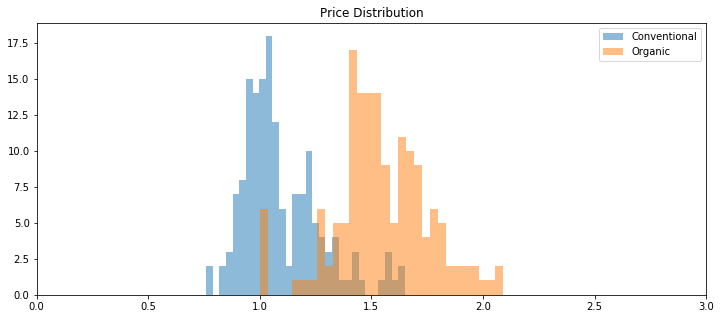

Mean Conventional: 1.0944585987261146
Mean Organic: 1.5454140127388534
St Dev Conventional: 0.17859463727749073
St Dev Organic: 0.2094806755627268


In [5]:
# Plot distribution of price by conventional and organic

plt.figure(figsize=(12,5))
plt.title('Price Distribution')
plt.hist(x=df_us[df_us['type']=='conventional']['average_price'], bins=30, alpha=.5, label= 'Conventional')
plt.hist(x=df_us[df_us['type']=='organic']['average_price'], bins=30, alpha=.5, label='Organic')
plt.xlim(0,3.0)

plt.legend(loc='upper right')
plt.show()

print('Mean Conventional: ' + str(np.mean(df_us[df_us['type']=='conventional']['average_price'])))
print('Mean Organic: ' + str(np.mean(df_us[df_us['type']=='organic']['average_price'])))
print('St Dev Conventional: ' + str(np.std(df_us[df_us['type']=='conventional']['average_price'])))
print('St Dev Organic: ' + str(np.std(df_us[df_us['type']=='organic']['average_price'])))

### Exploration: Avocados per Capita

<font size=3 >To get a better understanding of how the regions are defined and their relative avocado consumption I start by graphing avocado consumption per capita by region. The original data source did not include this metric, so I turned to Wikipedia for recent population stats on the regions involved. </font>

In [6]:
# Total volume of avocados sold by region
df_total_volume = pd.DataFrame(df_avo.pivot_table(
    index=['region_name'], aggfunc=sum)['total_volume'].sort_values(ascending=False))

# Join population to total volume
df_pop = pd.DataFrame(pd.read_csv('thinkful_datasets/pop_us.csv',header=0))
df_total_volume = df_total_volume.join(df_pop.set_index('region_name'), on='region_name', how='inner')

# Function for dividing columns accross rows that avoids errors caused by dividing by zero
def divide_by_zero(numerator, denominator):
    if denominator == 0:
        return 0
    else:
        return numerator/denominator

# Calculate avocado per capita by region
df_total_volume['avo_per_capita'] = df_total_volume.apply(
    lambda x: divide_by_zero(x.total_volume, x.est_pop), axis=1)

df_total_volume = df_total_volume.sort_values(by='avo_per_capita', ascending=False).reset_index()

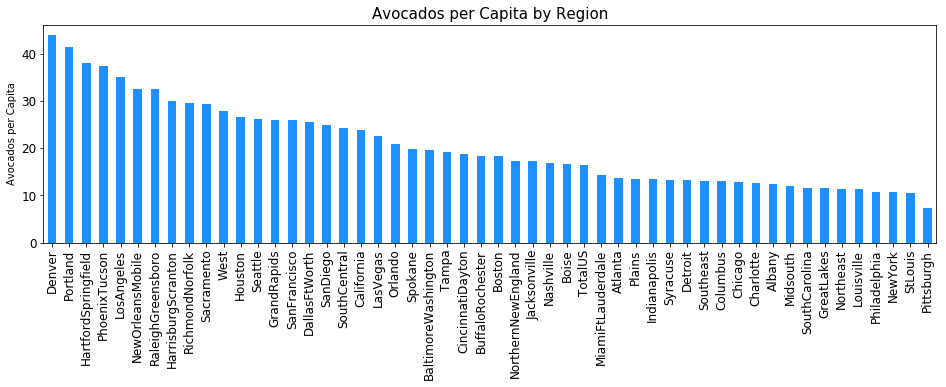

In [7]:
# Plot 
ax = df_total_volume.plot(kind='bar', x='region_name', y='avo_per_capita', legend=False, 
                          figsize=(16,4), fontsize=12, color='dodgerblue')

ax.set_ylabel('Avocados per Capita')
ax.set_xlabel('')
ax.set_title('Avocados per Capita by Region', fontsize=15)

plt.show()

<font size="3">Looking at avocados per capita we quickly see that there is a mix of different sized regions and a pretty wide spread of avocados per person.  Remembering that this is avocados per person over 3 years makes the left side of the graph less extreme though still suspicious.  This may be a result in mismatched regional definitions, quite a few on the high end are a combination of regions which made it harder to interpret which areas to include in my population calculations. </font>

## 1. In what region is it best to live if you are price sensitive and love avocados?

<font size="3"> To answer this question we'll dive deeper into the distribution of price and volume sold for the 8 major regions in the US.</font>

<font size="3"> A quick look at the summary table below indicates that South Central is the most affordable region in both conventional and organic categories. In fact, South Central organic avocados are even priced competitively to conventional avocados sold in the Northeast.</font>


In [8]:
# Create Region dataset
df_region = df_avo[df_avo['region_type']=='region'].reset_index(drop=True)
df_region.groupby(['type','region_name']).describe()['average_price'].sort_values(
    by='mean', ascending=True).iloc[:,1:]

mean       std   min   25%   50%   75%   max
type         region_name                                                   
conventional SouthCentral  0.874268  0.141870  0.62  0.79  0.84  0.93  1.34
             West          0.985414  0.181435  0.66  0.88  0.95  1.04  1.62
             California    1.107452  0.236065  0.67  0.94  1.08  1.20  1.78
             Southeast     1.164268  0.213410  0.62  0.99  1.15  1.32  1.82
             Plains        1.169682  0.200625  0.76  1.05  1.11  1.29  1.81
             GreatLakes    1.184586  0.219622  0.73  1.04  1.12  1.32  1.98
             Midsouth      1.211083  0.161128  0.91  1.09  1.17  1.33  1.72
organic      SouthCentral  1.327707  0.199968  0.97  1.15  1.35  1.45  1.81
conventional Northeast     1.347516  0.195037  0.87  1.20  1.33  1.51  1.75
organic      GreatLakes    1.501720  0.196009  0.83  1.39  1.54  1.65  1.89
             West          1.555223  0.359559  0.90  1.29  1.52  1.75  2.52
             Midsouth      1.605541  0.193707  1.02  1.49  1.60  1.71  2.17
             Southeast     1.646306  0.230096  1.11  1.47  1.64  1.78  2.33
             California    1.680764  0.298025  1.10  1.48  1.61  1.91  2.58
             Plains        1.715096  0.169216  1.29  1.60  1.70  1.84  2.13
             Northeast     1.875860  0.159422  1.43  1.78  1.88  1.96  2.31

<font size=3>Before relocating to Texas an avocado aficionado should also check to make sure there will be sufficient quantities of avocados available. In the boxplots below, there seems to be an inverse relationship between supply and price. Not only does the South Central region have the most affordable avocados they are also on the high end of avocados per capita.</font>

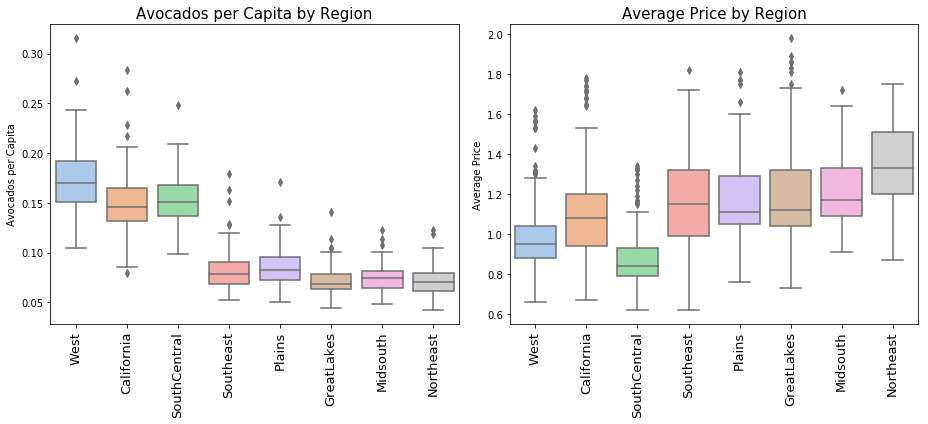

In [9]:
# Use divide_by_zero function to find avocados per capita
df_region['avo_per_capita'] = df_region.apply(lambda x: divide_by_zero(numerator = x.total_volume, denominator= x.est_pop), axis=1)
df_region = df_region.sort_values(by='avo_per_capita', ascending=False)
plt.figure(figsize=(13, 6))

plt.subplot(1,2,2)
sns.boxplot(x='region_name', y='average_price', 
            data=df_region[df_region['type']=='conventional'], palette='pastel')
plt.xticks(rotation=90)
plt.ylim=(0,3)
plt.ylabel('Average Price')
plt.xlabel(s="")
plt.title("Average Price by Region", fontsize=15)
plt.xticks(fontsize=13)

plt.subplot(1,2,1)
sns.boxplot(x='region_name', y='avo_per_capita', 
            data=df_region[df_region['type']=='conventional'], palette='pastel')
plt.xticks(rotation=90)
plt.ylim=(0,30)
plt.ylabel('Avocados per Capita')
plt.xlabel(s="")
plt.title("Avocados per Capita by Region", fontsize=15)
plt.xticks(fontsize=13)

plt.tight_layout()

<font size=3>We see a trend that South Central avocados are much cheaper and more plentiful than the Northeast, is this difference something that we quantify and prove is not an aberration in the data?<font>

In [10]:
#compare southcentral to northeast average price
df_southcentral = df_region[(df_region['type']=='conventional')&(
    df_region['region_name']=='SouthCentral')]['average_price'].reset_index(drop=True)
df_northeast = df_region[(df_region['type']=='conventional')&(
    df_region['region_name']=='Northeast')]['average_price'].reset_index(drop=True)

diff=df_northeast.mean( )-df_southcentral.mean()
print("Difference in means: {}".format(diff))

from scipy.stats import ttest_ind
print(ttest_ind(df_northeast, df_southcentral, equal_var=False))

Difference in means: 0.4732484076433122
Ttest_indResult(statistic=24.58683178510863, pvalue=2.0940153825719224e-72)


<font size=3> The t-stat above is pretty sizeable and the p-value is trending towards zero indicating that the large difference in average price distributions for Northeast and South Central were not a result of chance.</font>

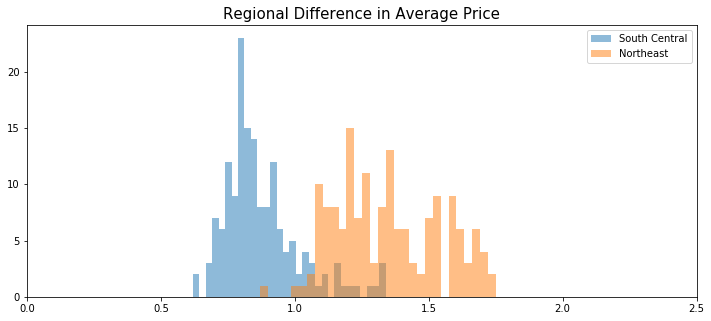

In [11]:
plt.figure(figsize=(12,5))
plt.title('Regional Difference in Average Price', fontsize=15)
plt.hist(x=df_southcentral, bins=30, alpha=.5, label='South Central')
plt.hist(x=df_northeast, bins=30, alpha=.5, label= 'Northeast')

plt.xlim(0,2.5)
plt.legend(loc='upper right', fontsize=10)
plt.show()

## 2. Is there a relationship between price and demand within a single region?

<font size="3"> To get a closer look at the relationship of price and demand in a single region I isolated the largest and smallest regions in the dataset, the West and the Plains respectively.</font>

In [12]:
# Create Plains and West datasets
df_plains = df_region[(df_region['type']=='conventional')&(df_region['region_name']=='Plains')].reset_index(drop=True)

df_west = df_region[(df_region['type']=='conventional')&(df_region['region_name']=='West')].reset_index(drop=True)

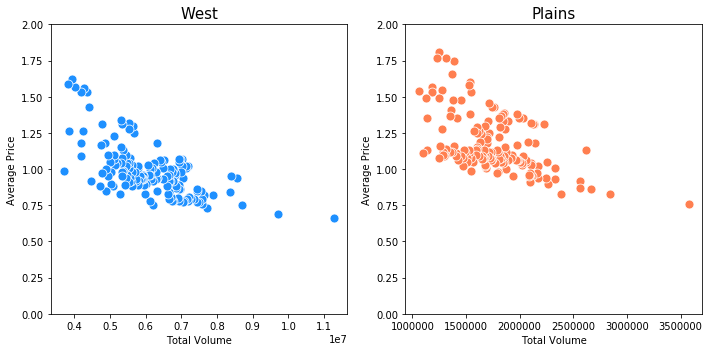

In [13]:
# Plot total volume sold vs. average price for 
fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
ax1 = sns.scatterplot(data= df_west, x=df_west['total_volume'], y=df_west['average_price'], 
                      color='dodgerblue', s=80)
ax1.set_ylabel('Average Price')
ax1.set_xlabel('Total Volume')
ax1.set_ylim(0,2)
ax1.set_title('West', fontsize=15)


plt.subplot(1,2,2)
ax2 = sns.scatterplot(data=df_plains, x=df_plains['total_volume'], y=df_plains['average_price'],
                      color='coral', s=80)
ax2.set_ylabel('Average Price')
ax2.set_xlabel('Total Volume')
ax2.set_ylim(0,2)
ax2.set_title('Plains', fontsize=15)


plt.tight_layout()
plt.show()

<font size=3>When plotted, both the West and Plains regions support my initial observation of an inverse relationship between total volume and price much like a traditional demand curve.  To quantify the difference in demand for high and low-priced avocados I compared the difference in total volume sold for weeks where average price is above and below the median.  Let's focus on the Plains region for this exercise. <font>

In [14]:
# Find the median average_price for plains region
plains_median = np.median(df_plains['average_price'])

# Seperate Plains events by those with an average_price above and below the median
below_median_price = df_plains[df_plains['average_price']<=plains_median]['total_volume'].reset_index(drop=True)
above_median_price = df_plains[df_plains['average_price']>plains_median]['total_volume'].reset_index(drop=True)

# Calculate the difference in volume sold 
mean_diff = below_median_price.mean() - above_median_price.mean()
print('Difference in Mean: {}'.format(mean_diff))

# T-test and p-value
print(ttest_ind(below_median_price,above_median_price, equal_var=False))

Difference in Mean: 258727.72671428532
Ttest_indResult(statistic=4.651244806972227, pvalue=7.22632841973377e-06)


<font size=3>From the t-test we do so a difference between the high and low-price samples that is statistically significant although the difference is not as stark as the difference in price between regions. <font>

## 3. I can never seem to finish an entire bag of avocados before they go bad, how prevalent are extra-large bag?
<font size=3> While extra-large bags actually don't seem to be that attractive to consumers, their popularity has been growing over the years.  Even more impressive is the growth of large bags from 17.2% to 24.4% over 2 years.</font>


In [15]:
us_sum = df_us.groupby('year').sum()[['total_bags','small_bags','large_bags','xlarge_bags']]
bags = us_sum.transpose()[1:]

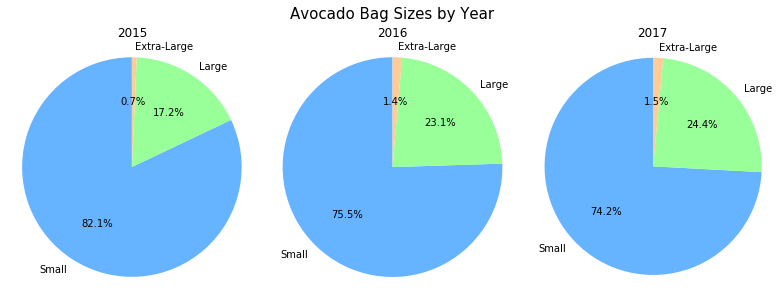

In [16]:
bags.index = ['Small', 'Large', 'Extra-Large']
fig = plt.figure(1, figsize=[11,4])

ax = fig.add_subplot(111)
#add colors
colors = ['#66b3ff','#99ff99','#ffcc99']
fig.suptitle('Avocado Bag Sizes by Year', fontsize=15, verticalalignment='bottom')
plt.subplots_adjust(left=.3, wspace=0.8, top=15)

for i,column in enumerate(bags.columns):
    plt.subplot(1,3,i+1)
    plt.pie(bags[column], colors=colors, labels=bags.index, startangle=90, autopct='%1.1f%%', radius=.6)
    plt.axis('equal')
    plt.title(column, fontsize=12, verticalalignment='bottom', horizontalalignment='center')


plt.tight_layout()
plt.show()

<font size=3> While we see a difference overall from year-to-year, my original question was more interested in whether certain regions of the country are more apt to purchase avocados in bulk.</font>

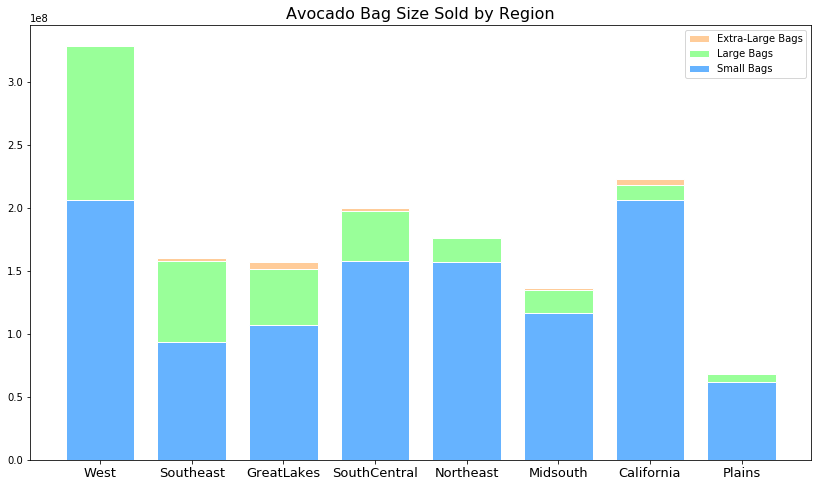

In [17]:
# Isolate bag size by region
region_sum = df_region.groupby('region_name').sum()[['total_bags','small_bags','large_bags','xlarge_bags']]
region_sum = region_sum.sort_values(by='large_bags', ascending=False)
fig = plt.figure(1, figsize=[14,8])
r = np.arange(len(region_sum.index))

# From raw value to percentage
smallBags = region_sum['small_bags']
largeBags = region_sum['large_bags']
xLargeBags = region_sum['xlarge_bags']

# plot
barWidth = 0.75
names = region_sum.index

# Create xlarge bags bars
plt.bar(r, xLargeBags, bottom=[i+j for i,j in zip(largeBags,smallBags)], color='#ffcc99',
        edgecolor='white', width=barWidth, label='Extra-Large Bags')
# Create  large bags bars
plt.bar(r, largeBags, bottom=smallBags, color='#99ff99', 
        edgecolor='white', width=barWidth, label='Large Bags')
# Create small bags bars
plt.bar(r, smallBags, color='#66b3ff', edgecolor='white',
        width=barWidth, label='Small Bags')

 
# Custom x axis
plt.xticks(r, names, fontsize=13)
plt.xlabel("")
plt.title("Avocado Bag Size Sold by Region", fontsize=16) 
plt.legend(loc="upper right")
# Show graphic
plt.show()

<font size=3>We see large bags being most popular in the West, Southeast, and Great Lakes regions. This is especially interesting considering that the Great Lakes have a higher average price per avocado and midrange avocado per person. Perhaps avocado enthusiasts in these regions are buying avocados in bulk to offset the price. Alternatively, the large bags could be purchased by restaurants in this region more often and therefore are at a higher price. </font>

## Future Research
<font size=3> 
There are a few ways I would like to expand this research. 
    
* Compare avocado price/demand to other fruits and vegetables: Avocados are a trendy fruit, I predict that consumers will be less sensitive to price changes in avocados than other less popular fruits and vegetables.  
    
* Explore volume of avocados sold in different store types across the US: This data would reveal patterns in the context that consumers are eating avocados. For example, consumers who live alone in urban areas would likely eat at restaurants and purchase avocados individually at grocery stores while suburban families may be purchasing avocados in larger quantities at lower prices per avocado. 

* Examine demand curves for conventional vs. organic avocados: I predict that the demand curve for conventional avocados would be steeper than organic avocados.  Consumers who purchase organic avocados may be less price sensitive since they are already selecting produce that is significantly more expensive. </font>
